# Food 101 Image Classification using  EfficientNetB6

In [1]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bee9e020-8ef3-1208-8fbb-69ff127b7825)


In [2]:
!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 43.9 MB/s eta 0:00:00
TensorFlow version: 2.14.0-dev20230617
Notebook last run (end-to-end): 2023-06-18 01:04:16.320638


## Importing a helper file from GitHub which consists of Neccessary functions

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-06-18 01:04:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-18 01:04:16 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Importing Dataset

In [5]:
import tensorflow_datasets as tfds

In [6]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [7]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete9PJSYQ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete9PJSYQ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Understanding the Data

In [10]:
# Take one sample off the training data
one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [11]:
# What does one sample of our training data look like?
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 65
  Class name (str form): mussels
        


In [13]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 19,   6,   0],
        [ 29,  16,   8],
        [ 34,  21,  13],
        ...,
        [ 36,  19,   3],
        [ 35,  19,   3],
        [ 36,  20,   4]],

       [[ 20,   7,   0],
        [ 28,  15,   7],
        [ 34,  21,  13],
        ...,
        [ 37,  20,   4],
        [ 37,  20,   4],
        [ 37,  21,   5]],

       [[ 20,   7,   0],
        [ 25,  12,   4],
        [ 31,  18,  10],
        ...,
        [ 40,  21,   4],
        [ 40,  21,   4],
        [ 39,  22,   4]],

       ...,

       [[208, 206, 194],
        [209, 207, 195],
        [211, 209, 197],
        ...,
        [192, 196, 179],
        [190, 194, 177],
        [203, 207, 190]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [203, 207, 190],
        [211, 214, 197],
        [202, 205, 186]],

       [[208, 206, 194],
        [209, 207, 195],
        [210, 208, 196],
        ...,
        [200, 204, 18

In [14]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

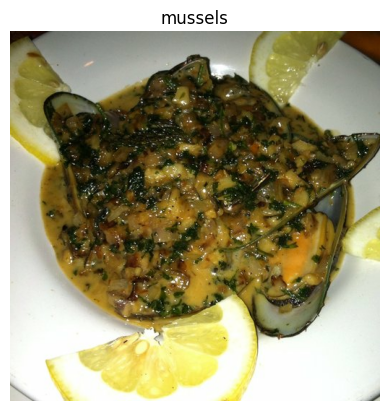

In [15]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

# Data Preprocessing

The data is resized to 244x244.

Please note we did not perform normalization because the EffecientNetB6 model has a normalization layer at the begining

In [16]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [17]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[19  6  0]
  [29 16  8]
  [34 21 13]
  ...
  [36 19  3]
  [35 19  3]
  [36 20  4]]

 [[20  7  0]
  [28 15  7]
  [34 21 13]
  ...
  [37 20  4]
  [37 20  4]
  [37 21  5]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[25.244898   12.244898    4.7295923 ]
  [32.40816    19.408163   11.408163  ]
  [32.719387   19.719387   10.719387  ]
  ...
  [39.005093   20.994862    3.4999783 ]
  [36.31123    19.31123     2.1173685 ]
  [36.413277   20.000034    4.000035  ]]

 [[19.897957    6.897958    0.18367267]
  [28.943878   15.943878    7.9438777 ]
  [22.112244    9.112244    1.1122437 ]
  ...
  [48.89794    27.015284    6.1428356 ]
  [44.642845   23.852028    3.0714417 ]
  [42.7602     21.954084    3.0714283 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


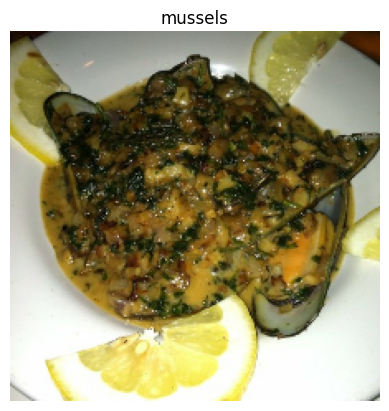

In [18]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch and Prepare Dataset

We can see below that we are prefetching, multithreaded loading and preprocessing the data.

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)


In [19]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [21]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [22]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [23]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<Policy "mixed_float16">

In [24]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 2s 0us/step


In [25]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [26]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [27]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy

In [28]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetv2b0101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2b0101_classes_all_data_feature_extract/20230618-011917
Epoch 1/3
2368/2368 [==============================] - 213s 82ms/step - loss: 1.7445 - accuracy: 0.5769 - val_loss: 1.1492 - val_accuracy: 0.6933
Epoch 2/3
2368/2368 [==============================] - 202s 84ms/step - loss: 1.2122 - accuracy: 0.6866 - val_loss: 1.0229 - val_accuracy: 0.7240
Epoch 3/3
2368/2368 [==============================] - 198s 82ms/step - loss: 1.0633 - accuracy: 0.7217 - val_loss: 0.9992 - val_accuracy: 0.7352


In [29]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 56s 71ms/step - loss: 0.9989 - accuracy: 0.7289


[0.9988547563552856, 0.7288712859153748]

In [30]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 57s 68ms/step - loss: 0.9989 - accuracy: 0.7289


In [31]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all()

In [32]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Po

In [33]:
# # Create save path to drive
save_dir = "drive/MyDrive/tensorflow_course/food_vision/efficientnetv2b0_feature_extract_model_mixed_precision/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
model.save(save_dir)

In [34]:
# Save model locally (in colab instance)
save_dir = "efficientnetv2b0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [35]:
# Load model previously saved above
load_model = tf.keras.models.load_model(save_dir)

In [36]:
# Check the layers in the base model and see what dtype policy they're using
for layer in load_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Policy 

In [37]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [38]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [39]:
# Compile the model
load_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [41]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = load_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientv2b0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientv2b0_101_classes_all_data_fine_tuning/20230618-013435
Epoch 1/100
2368/2368 [==============================] - 241s 100ms/step - loss: 0.8995 - accuracy: 0.7702 - val_loss: 0.9535 - val_accuracy: 0.7479 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 195s 82ms/step - loss: 0.8874 - accuracy: 0.7738 - val_loss: 0.9561 - val_accuracy: 0.7471 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.7769
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 195s 81ms/step - loss: 0.8775 - accuracy: 0.7770 - val_loss: 0.9578 - val_accuracy: 0.7481 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 225s 94ms/step - loss: 0.8617 - accuracy: 0.7822 - val_loss: 0.9472 - val_accuracy: 0.7521 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - 193s 80m

In [42]:
results_fine_tuned_model = load_model.evaluate(test_data)
results_fine_tuned_model

790/790 [==============================] - 58s 73ms/step - loss: 0.9504 - accuracy: 0.7433


[0.9504312872886658, 0.7432871460914612]

In [54]:
pred_probs = load_model.predict(test_data, verbose=1)

790/790 [==============================] - 56s 71ms/step


In [60]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
   --name "Fine-tuning EfficientNetV2B0 on all Food101 Data" \
   --description "Training results for fine-tuning EfficientNetV2B0 on Food101 Data with learning rate 0.0001" \
   --one_shot

2023-06-18 03:00:43.642823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7622] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-18 03:00:43.643574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-18 03:00:43.644720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1497] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-18 03:00:46.068340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of